# Compute Dataset Stats

**Author:** Prisca Dotti

**Last modified:** 03/04/2024

Used this script for the following purposes:
- Load Excel Sheet that contains all metadata of the dataset
- Compute SNR on all samples
- Compute number of individual instances per type
- Analyze type of noise present in movies
- Create plot of sample individual events
- ...


In [2]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
# To import modules from parent directory in Jupyter Notebook
import sys

sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import logging
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

# from scipy.fft import fft2, fftshift
from skimage import morphology, exposure
from typing import Dict, List, Tuple

# from scipy.signal import find_peaks

from config import TrainingConfig, config
from data.data_processing_tools import (
    get_cell_mask,
    masks_to_instances_dict,
    remove_background,
    compute_snr,
)
from data.datasets import SparkDataset
from utils.training_script_utils import init_dataset
from utils.visualization_tools import add_scale_bar

# Setup logging
logging.basicConfig(level=logging.INFO)

logging.getLogger("matplotlib").setLevel(
    logging.WARNING
)  # Or use logging.ERROR to see only errors
logger = logging.getLogger(__name__)

config.verbosity = 3  # To get debug messages

In [6]:
# Get excel file with all the dataset metadata
metadata_path = (
    # r"C:\Users\dotti\OneDrive - Universitaet Bern\sparks_code_local\movies_summary.xlsx"
    r"C:\Users\prisc\OneDrive - Universitaet Bern\sparks_code_local\movies_summary.xlsx"
)
# Load the column "Movie ID" as string to avoid losing leading zeros
metadata_df = pd.read_excel(metadata_path, dtype={"Movie ID": str})
# Remove columns with "In Dataset" == "no"
metadata_df = metadata_df[metadata_df["In Dataset"] == "yes"]

In [7]:
metadata_df.head()

,Movie ID,In Dataset,Original Name,Mouse Model,Cell Type,Train/Test,Num Frames,Original Num Frames,Num Sparks,Num Puffs,Num Waves,Waves Remarks,Remarks,Acquisition Date,Cell Identifier,Pharmacology,FPS
0,01,yes,130906 C ET-1,WT Bl.6,atria,train,500,500,23,6,0,NaN,"1 spark manually added (P, frame 80), manual corr",2013-09-06,C,ET-1,138.8
1,02,yes,130918 C ET-1,WT Bl.6,atria,train,500,500,9,3,2,large,manual corr,2013-09-18,C,ET-1,147.5
2,03,yes,130921 E ET-1,WT Bl.6,atria,train,500,500,24,14,0,NaN,manual corr,2013-09-21,E,ET-1,147.5
3,04,yes,130926 C ET-1,WT Bl.6,atria,train,500,500,26,3,0,NaN,manual corr,2013-09-26,C,ET-1,147.5
4,05,yes,131104 D ET-1,WT Bl.6,atria,test,500,500,71,26,0,NaN,manual corr,2013-11-04,D,ET-1,139.7


In [8]:
############################ Get default parameters ############################

# Get dataset_ids as values in the "Movie ID" column
dataset_ids = list(metadata_df["Movie ID"].values)

# Get values in "Movie ID" column with column "Train/Test" == "test"
test_ids = list(metadata_df[metadata_df["Train/Test"] == "test"]["Movie ID"].values)

# Get values in "Movie ID" column with column "Train/Test" == "train"
train_ids = list(metadata_df[metadata_df["Train/Test"] == "train"]["Movie ID"].values)

# Get FPS for each sample
fps_dict = dict(metadata_df[["Movie ID", "FPS"]].values)

# sample_ids = dataset_ids
sample_ids = ["01", "05", "34"]

# Initialize general parameters with default values
params = TrainingConfig()

In [9]:
############################## Configure dataset ###############################

print(f"Loading samples\n{sample_ids}.")
print(f"Using {params.dataset_dir} as dataset root path.")

# Create dataset
dataset = init_dataset(
    params=params,
    sample_ids=sample_ids,
    apply_data_augmentation=False,
    print_dataset_info=True,
    load_instances=True,
)

Loading samples
['01', '05', '34'].
Using C:\Users\prisc\Code\sparks_project\data\sparks_dataset as dataset root path.


INFO:utils.training_script_utils:Samples in dataset: 40


### Compute SNR on all movies

In [8]:
movies = dataset.get_movies()
labeled_events = dataset.get_labels()

snr_dict = {}
snr_dict_no_bg = {}
percentile = 90

for sample_id in sample_ids:
    # print(f"Compkuting SNR for sample {sample_id}")
    idx = sample_ids.index(sample_id)
    x = movies[idx]
    cell_mask = get_cell_mask(x)
    x_no_bg = remove_background(x, mode="offline")
    y = labeled_events[idx]

    # compute signal-to-noise ratio
    snr_dict[sample_id] = compute_snr(x, y, percentile=percentile)
    snr_dict_no_bg[sample_id] = compute_snr(
        x_no_bg, y, cell_mask=cell_mask, percentile=percentile
    )

# Display the results
snr_df = pd.DataFrame.from_dict(
    snr_dict, orient="index", columns=[f"SNR_{percentile}th"]
)
snr_df = snr_df.sort_values(by=f"SNR_{percentile}th", ascending=False).reset_index()
snr_no_bg_df = pd.DataFrame.from_dict(
    snr_dict_no_bg, orient="index", columns=[f"SNR_{percentile}th"]
)
snr_no_bg_df = snr_no_bg_df.sort_values(
    by=f"SNR_{percentile}th", ascending=False
).reset_index()

# Merge data frames on 'Sample ID' or equivalent
merged_df = pd.merge(
    snr_df, snr_no_bg_df, on="index", suffixes=("_with_bg", "_without_bg")
)

# Sort merged_df by the SNR values from offline background removal in descending order
merged_df.sort_values(
    by=f"SNR_{percentile}th_without_bg", ascending=False, inplace=True
)

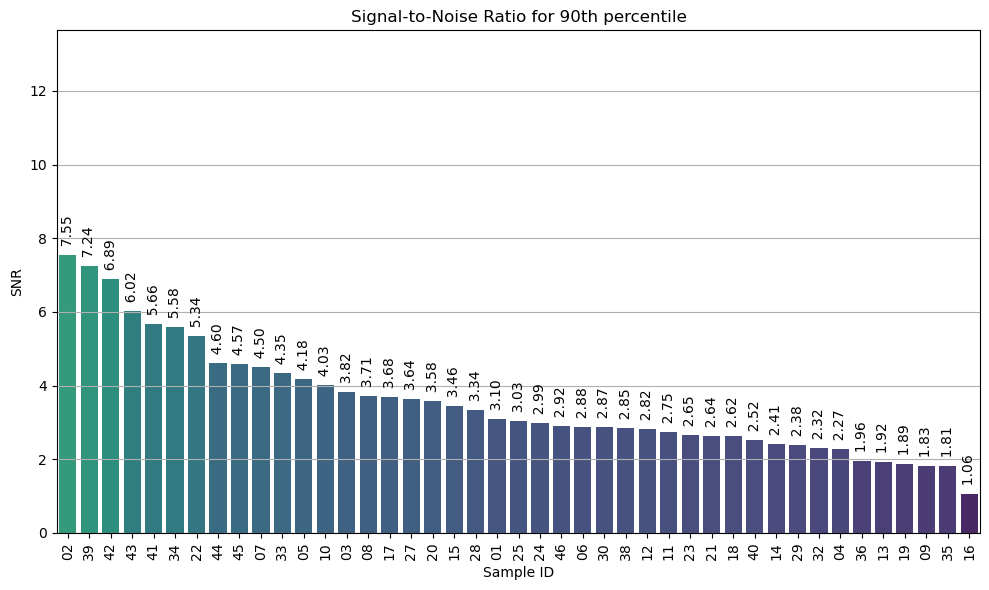

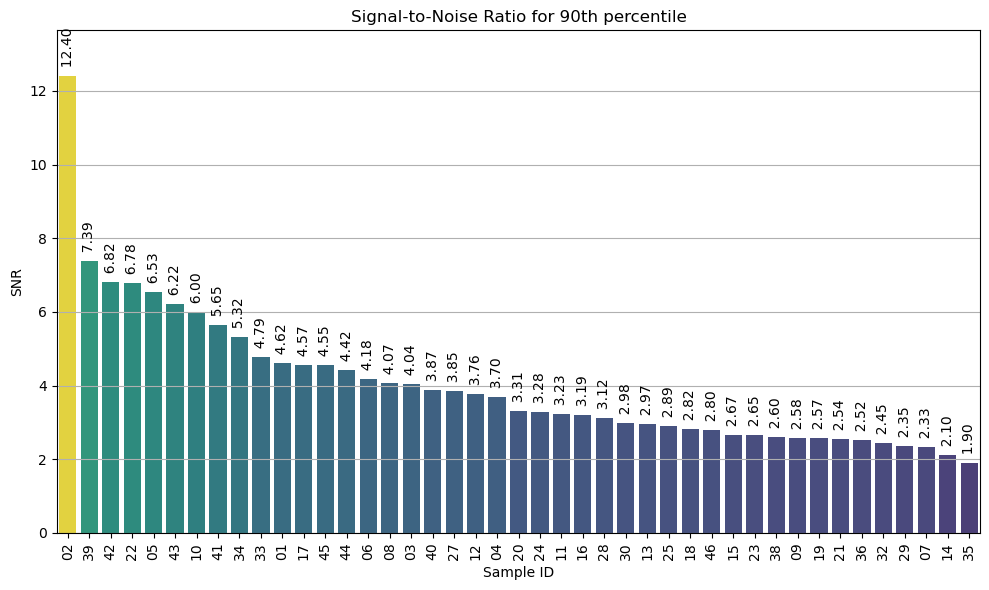

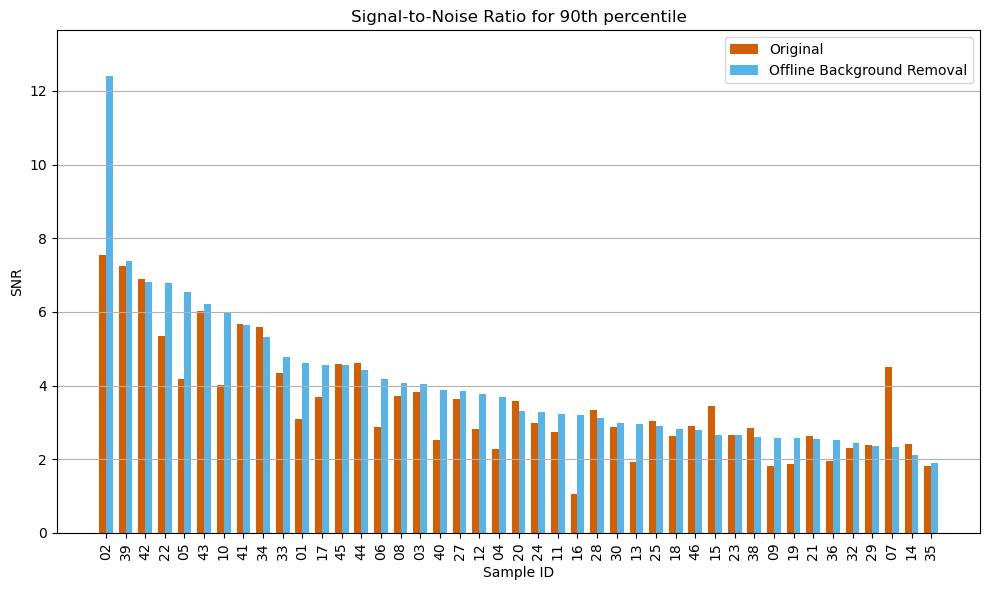

In [9]:
# Create color palettes that maps each SNR value to a color intensity
max_snr = snr_no_bg_df[f"SNR_{percentile}th"].max()
palette = [
    sns.color_palette("viridis", as_cmap=True)(value / max_snr)
    for value in snr_df[f"SNR_{percentile}th"]
]
palette_no_bg = [
    sns.color_palette("viridis", as_cmap=True)(value / max_snr)
    for value in snr_no_bg_df[f"SNR_{percentile}th"]
]

# Plot the SNR values
plt.figure(figsize=(10, 6))  # Increased figure size for clarity
sns.barplot(
    x="index",
    y=f"SNR_{percentile}th",
    data=snr_df,
    palette=palette,
    hue="index",
    dodge=False,
)
plt.title(f"Signal-to-Noise Ratio for {percentile}th percentile")
plt.ylabel("SNR")
plt.xlabel("Sample ID")
plt.ylim(0, max_snr * 1.1)  # Set the y-axis limits to show all values
plt.xticks(rotation=90)  # Rotate for better readability
plt.grid(axis="y")  # Add gridlines
plt.legend([], [], frameon=False)  # Remove legend

# Adding SNR values on top of the bars
for index, value in enumerate(snr_df[f"SNR_{percentile}th"]):
    plt.text(
        index,
        value,
        f"  {value:.2f}",
        ha="center",
        va="bottom",
        rotation=90,
        color="black",
    )

# Show the plot
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

# Plot the SNR values
plt.figure(figsize=(10, 6))  # Increased figure size for clarity
sns.barplot(
    x="index",
    y=f"SNR_{percentile}th",
    data=snr_no_bg_df,
    palette=palette_no_bg,
    hue="index",
    dodge=False,
)
plt.title(f"Signal-to-Noise Ratio for {percentile}th percentile")
plt.ylabel("SNR")
plt.xlabel("Sample ID")
plt.ylim(0, max_snr * 1.1)  # Set the y-axis limits to show all values
plt.xticks(rotation=90)  # Rotate for better readability
plt.grid(axis="y")  # Add gridlines
plt.legend([], [], frameon=False)  # Remove legend

# Adding SNR values on top of the bars
for index, value in enumerate(snr_no_bg_df[f"SNR_{percentile}th"]):
    plt.text(
        index,
        value,
        f"  {value:.2f}",
        ha="center",
        va="bottom",
        rotation=90,
        color="black",
    )

# Show the plot
plt.tight_layout()  # Adjust layout to fit everything
plt.show()


# Set up the matplotlib figure and axes
plt.figure(figsize=(10, 6))

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars
indices = range(len(merged_df))
pos_with_bg = indices
pos_without_bg = [p + bar_width for p in pos_with_bg]

# Choose a color palette
colors = sns.color_palette("colorblind")


# Plotting both 'With Background' and 'Without Background' bars
plt.bar(
    pos_with_bg,
    merged_df[f"SNR_{percentile}th_with_bg"],
    width=bar_width,
    label="Original",
    color=colors[3],
)
plt.bar(
    pos_without_bg,
    merged_df[f"SNR_{percentile}th_without_bg"],
    width=bar_width,
    label="Offline Background Removal",
    color=colors[9],
)

# Add some text for labels, title, and axes ticks
plt.xlabel("Sample ID")
plt.ylabel("SNR")
plt.title(f"Signal-to-Noise Ratio for {percentile}th percentile")
plt.xticks([p + bar_width / 2 for p in pos_with_bg], merged_df["index"], rotation=90)
plt.ylim(0, max_snr * 1.1)

# Add legend
plt.legend()

# Grid lines
plt.grid(axis="y")

# Make layout tight
plt.tight_layout()

# Save as a high quality PNG file
# plt.savefig("snr_comparison.png", dpi=300)

# Show the plot
plt.show()

In [10]:
# Compute number of sample ids for which SNR is higher with offline background removal
n_samples = len(merged_df)
n_samples_with_bg = len(
    merged_df[
        merged_df[f"SNR_{percentile}th_with_bg"]
        > merged_df[f"SNR_{percentile}th_without_bg"]
    ]
)
n_samples_without_bg = len(
    merged_df[
        merged_df[f"SNR_{percentile}th_with_bg"]
        < merged_df[f"SNR_{percentile}th_without_bg"]
    ]
)

# Compute the percentage of sample ids for which SNR is higher with offline background removal
percent_samples_with_bg = n_samples_with_bg / n_samples * 100
percent_samples_without_bg = n_samples_without_bg / n_samples * 100

# Print the results
print(f"Number of samples: {n_samples}")
print(f"Number of samples with higher SNR in original sample: {n_samples_with_bg}")
print(
    f"Number of samples with higher SNR without offline background: {n_samples_without_bg}"
)
print(
    f"Percentage of samples with higher SNR in original sample: {percent_samples_with_bg:.2f}%"
)
print(
    f"Percentage of samples with higher SNR without offline background: {percent_samples_without_bg:.2f}%"
)

Number of samples: 43
Number of samples with higher SNR in original sample: 16
Number of samples with higher SNR without offline background: 27
Percentage of samples with higher SNR in original sample: 37.21%
Percentage of samples with higher SNR without offline background: 62.79%


### Analyze number of events in movies

In [9]:
instances = dataset.get_instances()
labels = dataset.get_labels()

In [10]:
# Compute the number of instances per class per movie
n_instances_per_movie = {movie_id: {} for movie_id in sample_ids}

for sample_id, i, l in zip(sample_ids, instances.values(), labels.values()):
    movie_instances_dict = masks_to_instances_dict(i, l)

    n_instances_per_type = {
        c: len(np.unique(i)) - 1 for c, i in movie_instances_dict.items()
    }
    n_instances_per_movie[sample_id] = n_instances_per_type

In [11]:
# Convert nested dictionary into a DataFrame for easier analysis
instances_df = pd.DataFrame.from_dict(n_instances_per_movie, orient="index")

# Calculate total number of each event type across all movies
total_events = instances_df.sum()

# Calculate average number of each event type per movie
average_events = instances_df.mean()

# Find the movie with the maximum number of each event type
max_events = instances_df.idxmax()

# Gather statistics in a dictionary for easier presentation
stats = {
    "total_sparks": total_events["sparks"],
    "total_waves": total_events["waves"],
    "total_puffs": total_events["puffs"],
    "average_sparks": average_events["sparks"],
    "average_waves": average_events["waves"],
    "average_puffs": average_events["puffs"],
    "movie_most_sparks": (
        max_events["sparks"],
        instances_df.loc[max_events["sparks"]]["sparks"],
    ),
    "movie_most_waves": (
        max_events["waves"],
        instances_df.loc[max_events["waves"]]["waves"],
    ),
    "movie_most_puffs": (
        max_events["puffs"],
        instances_df.loc[max_events["puffs"]]["puffs"],
    ),
    "total_instances": instances_df.sum(axis=1).sum(),  # Total of all instances
}

stats

{'total_sparks': 1380,
 'total_waves': 37,
 'total_puffs': 299,
 'average_sparks': 32.093023255813954,
 'average_waves': 0.8604651162790697,
 'average_puffs': 6.953488372093023,
 'movie_most_sparks': ('23', 188),
 'movie_most_waves': ('38', 8),
 'movie_most_puffs': ('05', 26),
 'total_instances': 1716}

In [20]:
# instances_df

In [13]:
# Convert the DataFrame to a binary DataFrame where 1 indicates the presence of an event
movies_with_events = (instances_df > 0).astype(int)

# Sum each column to get the number of movies that contain each event type
n_movies_with_events = movies_with_events.sum()

# Output the results
for event_type, n_movies in n_movies_with_events.items():
    print(f"Number of movies with {event_type}: {n_movies}")

Number of movies with sparks: 40
Number of movies with waves: 16
Number of movies with puffs: 37


In [17]:
# Initialize dictionaries to count the number of each event type in the test and train datasets
train_event_counts = {"sparks": 0, "waves": 0, "puffs": 0}
test_event_counts = {"sparks": 0, "waves": 0, "puffs": 0}

# Iterate over the nested dictionary to sum the events for each dataset
for sample_id, events in n_instances_per_movie.items():
    if sample_id in train_ids:
        for event, count in events.items():
            train_event_counts[event] += count
    elif sample_id in test_ids:
        for event, count in events.items():
            test_event_counts[event] += count

In [18]:
# Calculate the ratios of each event type in the train dataset vs. the test dataset
ratios = {}
for event_type in train_event_counts.keys():
    if test_event_counts[event_type] > 0:  # To avoid division by zero
        ratios[event_type] = (
            train_event_counts[event_type] / test_event_counts[event_type]
        )
    else:
        ratios[event_type] = float(
            "inf"
        )  # If the event type is not present in the test dataset at all

# Given the ratios, convert them to percentages
percentages = {}
for event_type in train_event_counts.keys():
    percentages[event_type] = (
        100
        * test_event_counts[event_type]
        / (train_event_counts[event_type] + test_event_counts[event_type])
    )

percentages

{'sparks': 19.202898550724637,
 'waves': 18.91891891891892,
 'puffs': 24.74916387959866}

### Analyze type of noise in samples

#### Methods

##### Plot functions

In [39]:
def plot_simple_sample_analysis(
    mean_intensity_map: np.ndarray,
    sample_id: str,
    fps: float,
    snr: float,
    blank_mask: np.ndarray,
    cell_mask: np.ndarray,
    blank_pixels_t_profile: np.ndarray,
    mean_values_t_profile: np.ndarray,
    variance_values_t_profile: np.ndarray,
    coeff_var_map: np.ndarray,
    figsize: Tuple[int, int],
):
    # Create a grid layout for the figure
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 4, 4], figure=fig)

    ### Mean movie frame with contour overlays ###
    ax_movie = fig.add_subplot(gs[0, 0])
    vmin = np.percentile(mean_intensity_map, 1)
    vmax = np.percentile(mean_intensity_map, 99)
    norm = Normalize(vmin=vmin, vmax=vmax)
    # equalized_mean_frame = exposure.equalize_adapthist(mean_intensity_map)
    im_movie = ax_movie.imshow(mean_intensity_map, cmap="gray", norm=norm)
    ax_movie.contour(blank_mask, colors="yellow", alpha=0.7)
    ax_movie.contour(cell_mask, colors="lightblue", alpha=0.7)
    ax_movie.axis("off")
    ax_movie.set_title("Mean Intensity Map")
    add_scale_bar(
        ax_movie,
        pixel_size=0.2,
        bar_length_um=10,
        bar_height_um=0.4,
        bar_color="white",
        bar_location=(7, mean_intensity_map.shape[0] - 7),
        text_location=(7, mean_intensity_map.shape[0] - 10),
    )
    divider = make_axes_locatable(ax_movie)
    cax = divider.append_axes("right", pad=0.1, size="1%")
    cbar = plt.colorbar(
        im_movie,
        cax=cax,
        orientation="vertical",
        fraction=0.046,
        pad=0.04,
    )
    cbar.set_ticks([vmin, vmax])
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: "{:0.2f}".format(x))
    )
    cbar.ax.set_title("Mean\nIntensity", fontsize=8)

    ### Coefficient of variation map with contour overlays and a colorbar ###
    ax_cv = fig.add_subplot(gs[1, 0])
    vmin = np.percentile(coeff_var_map, 1)
    vmax = np.percentile(coeff_var_map, 99)
    norm = Normalize(vmin=vmin, vmax=vmax)
    im_cv = ax_cv.imshow(coeff_var_map, cmap="magma", norm=norm)
    ax_cv.contour(blank_mask, colors="yellow", alpha=0.9)
    ax_cv.contour(cell_mask, colors="lightblue", alpha=0.9)
    ax_cv.set_title(f"Coefficient of Variation Map")
    ax_cv.axis("off")
    # Add the colorbar
    divider = make_axes_locatable(ax_cv)
    cax = divider.append_axes("right", pad=0.1, size="1%")
    cbar = plt.colorbar(
        im_cv,
        cax=cax,
        orientation="vertical",
        fraction=0.046,
        pad=0.04,
    )
    cbar.set_ticks([vmin, vmax])
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: "{:0.2f}".format(x))
    )
    cbar.ax.set_title("Variance\nCoefficient", fontsize=8)

    ### Mean-Variance Analysis ###
    ax_m_v = fig.add_subplot(gs[2, 0])
    sns.scatterplot(
        x=mean_values_t_profile,
        y=variance_values_t_profile,
        ax=ax_m_v,
        alpha=0.7,
        c="seagreen",
        edgecolor=None,
        size=0.6,
    )
    ax_m_v.set_title("Mean-Variance Analysis")
    ax_m_v.set_xlabel("Mean Intensity [AU]")
    ax_m_v.set_ylabel("Variance")
    ax_m_v.grid(True)
    ax_m_v.tick_params(labelsize=8)
    ax_m_v.legend([], [], frameon=False)
    ax_m_v.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: "{:0.2g}".format(x))
    )
    ax_m_v.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax_m_v.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

    ### Temporal profile of blank region ###
    ax_t = fig.add_subplot(gs[3, 0])
    # Use ms in x axis instead of frames
    t_axis = np.linspace(
        0, len(blank_pixels_t_profile) / fps, num=len(blank_pixels_t_profile)
    )
    sns.lineplot(
        ax=ax_t,
        x=t_axis,
        y=blank_pixels_t_profile,
        color="midnightblue",
        linewidth=0.7,
    )
    ax_t.set_title(f"Temporal Profile in Blank Region")
    ax_t.set_xlabel("Time [ms]")
    ax_t.set_ylabel("Mean Intensity [AU]")
    ax_t.set_xlim(0, 3)  # Adjust the x-axis limits as necessary
    ax_t.grid(True)
    ax_t.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: "{:0.1f}".format(x))
    )
    ax_t.tick_params(labelsize=8)
    ax_t.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax_t.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

    # Add figure title
    fig.suptitle(
        f"Sample Analysis for Sample {sample_id}\n(fps = {fps} Hz, SNR = {snr:.2g} dB)",
        fontsize=12,
        y=1.05,
    )

    # Align ax_movie and ax_cv to the left side of ax_t and ax_m_v tick labels
    # fig.tight_layout(rect=(0, 0.03, 1, 0.92))

    # Save the figure to a file
    fig.savefig(
        f"noise_sample_{sample_id}.png",
        dpi=300,
        bbox_inches="tight",
        # pad_inches=0.1
    )

    plt.show()


# def add_colorbar(im, ax, ticks, orientation="vertical", label: str = ""):
#     """Add a colorbar to the in a new axis."""
#     divider = make_axes_locatable(ax)
#     # cax = divider.append_axes("right", size="5%", pad=0.05)
#     cax = divider.append_axes("right", pad=0.1, size="1%")
#     cbar = plt.colorbar(im, cax=cax, orientation=orientation, shrink=0.5)
#     cbar.set_ticks(ticks)
#     cbar.ax.yaxis.set_major_formatter(
#         ticker.FuncFormatter(lambda x, pos: "{:0.2f}".format(x))
#     )
#     if label:
#         cbar.set_label(label)

# def plot_sample_analysis(
#     temporal_diff_std_t_profile,
#     mean_values_t_profile,
#     variance_values_t_profile,
#     no_bg_frames_to_inspect,
#     no_bg_magnitude_spectra_2d,
#     frame_names,
#     no_bg_magnitude_spectrum_t_profile,
#     fps,
#     original_movie: np.ndarray,
#     sample_id: str,
#     blank_mask: np.ndarray,
#     cell_mask: np.ndarray,
#     mean_intensity_map: np.ndarray,
#     std_intensity_map: np.ndarray,
#     coeff_var_map: np.ndarray,
#     blank_pixels: np.ndarray,
#     cell_pixels: np.ndarray,
#     blank_pixels_t_profile: np.ndarray,
#     figsize: Tuple[int, int],
# ):
#     # Create a grid layout for the figure
#     fig = plt.figure(figsize=figsize)
#     rows = len(no_bg_magnitude_spectra_2d) * 2 + 5
#     height_ratios = [0.8, 0.8, 0.8, 4, 0.05] + [0.8] * (rows - 5)
#     width_ratios = [1, 0.01, 1]
#     gs = gridspec.GridSpec(
#         rows,
#         3,
#         height_ratios=height_ratios,
#         width_ratios=width_ratios,
#     )

#     ### Mean movie frame with contour overlays ###
#     ax1 = fig.add_subplot(gs[0, 0])
#     mean_frame = np.mean(original_movie, axis=0)
#     equalized_mean_frame = exposure.equalize_adapthist(mean_frame)
#     ax1.imshow(equalized_mean_frame, cmap="gray")
#     ax1.contour(blank_mask, colors="lightsalmon", alpha=0.8)
#     ax1.contour(cell_mask, colors="yellowgreen", alpha=0.8)
#     ax1.axis("off")
#     add_scale_bar(
#         ax1,
#         pixel_size=0.2,
#         bar_length_um=10,
#         bar_height_um=0.4,
#         bar_color="white",
#         bar_location=(original_movie.shape[2] - 60, original_movie.shape[1] - 7),
#         text_location=(original_movie.shape[2] - 10, original_movie.shape[1] - 10),
#     )
#     ax1.set_title("Mean Movie Frame with Blank Region and Cell Contour")
#     divider = make_axes_locatable(ax1)
#     cax = divider.append_axes("right", pad=0.1, size="1%")
#     cax.axis("off") # "empty" colorbar

#     ### Temporal difference standard deviation map ###
#     ax2 = fig.add_subplot(gs[0, -1])
#     norm = Normalize(
#         vmin=temporal_diff_std_t_profile.min(), vmax=temporal_diff_std_t_profile.max()
#     )
#     im = ax2.imshow(temporal_diff_std_t_profile, cmap="hot", norm=norm)
#     ax2.contour(blank_mask, colors="lightsalmon", alpha=0.8)
#     ax2.contour(cell_mask, colors="yellowgreen", alpha=0.8)
#     ax2.axis("off")
#     ax2.set_title(f"Temporal Difference Standard Deviation Map")
#     ticks = [np.min(temporal_diff_std_t_profile), np.max(temporal_diff_std_t_profile)]
#     add_colorbar(im=im, ax=ax2, ticks=ticks, orientation="vertical", label="")

#     ### Mean intensity map with contour overlays and a colorbar ###
#     ax3 = fig.add_subplot(gs[1, 0])
#     mean_im = ax3.imshow(mean_intensity_map, cmap="viridis")
#     ax3.contour(blank_mask, colors="lightsalmon", alpha=0.8)
#     ax3.contour(cell_mask, colors="yellowgreen", alpha=0.8)
#     ax3.set_title(f"Mean Intensity Map of Blank Region")
#     ax3.axis("off")
#     ticks = [np.min(mean_intensity_map), np.max(mean_intensity_map)]
#     add_colorbar(im=mean_im, ax=ax3, ticks=ticks, orientation="vertical", label="")

#     ###  Standard deviation map with contour overlays and a colorbar ###
#     ax4 = fig.add_subplot(gs[1, -1])
#     std_im = ax4.imshow(std_intensity_map, cmap="hot")
#     ax4.contour(blank_mask, colors="lightsalmon", alpha=0.8)
#     ax4.contour(cell_mask, colors="yellowgreen", alpha=0.8)
#     ax4.set_title(f"Standard Deviation Map of Blank Region for Sample {sample_id}")
#     ax4.axis("off")
#     ticks = [np.min(std_intensity_map), np.max(std_intensity_map)]
#     add_colorbar(im=std_im, ax=ax4, ticks=ticks, orientation="vertical", label="")

#     ###  Coefficient of variation map with contour overlays and a colorbar ###
#     ax5 = fig.add_subplot(gs[2, 0])
#     cv_im = ax5.imshow(coeff_var_map, cmap="viridis")
#     ax5.contour(blank_mask, colors="lightsalmon", alpha=0.8)
#     ax5.contour(cell_mask, colors="yellowgreen", alpha=0.8)
#     ax5.set_title(f"Coefficient of Variation Map for Sample {sample_id}")
#     ax5.axis("off")
#     ticks = [np.min(coeff_var_map), np.max(coeff_var_map)]
#     add_colorbar(im=cv_im, ax=ax5, ticks=ticks, orientation="vertical", label="")

#     ### Histogram of the pixel intensities for blank region and cell ###
#     ax6 = fig.add_subplot(gs[3, 0])
#     ax6.hist(
#         blank_pixels.ravel(), bins=100, color="skyblue", alpha=0.6, edgecolor="black"
#     )
#     ax6.hist(
#         cell_pixels.ravel(), bins=100, color="salmon", alpha=0.6, edgecolor="black"
#     )
#     ax6.set_title(
#         f"Intensity Histogram of Blank Region and Cell for Sample {sample_id}"
#     )
#     ax6.set_xlabel("Intensity")
#     ax6.set_ylabel("Pixel Count")
#     ax6.legend(["Blank Region", "Cell"])
#     ax6.grid(True)

#     ### Mean-Variance Analysis ###
#     ax7 = fig.add_subplot(gs[2:4, -1])
#     sns.scatterplot(
#         x=mean_values_t_profile,
#         y=variance_values_t_profile,
#         ax=ax7,
#         alpha=0.7,
#     )
#     ax7.set_title("Mean-Variance Analysis")
#     ax7.set_xlabel("Mean Intensity [AU]")
#     ax7.set_ylabel("Variance")
#     ax7.grid(True)

#     ### Temporal profile of blank region ###
#     ax8 = fig.add_subplot(gs[5:-3, -1])
#     # Use ms in x axis instead of frames
#     x_axis = np.arange(len(blank_pixels_t_profile)) / fps * 1000
#     sns.lineplot(ax=ax8, x=x_axis, y=blank_pixels_t_profile, color="royalblue")
#     ax8.set_title(f"Temporal Fluctuations in Blank Region")
#     ax8.set_xlabel("Time [ms]")
#     ax8.set_ylabel("Mean Intensity [AU]")
#     ax8.set_xlim(0, len(blank_pixels_t_profile) / fps * 1000)

#     ### 2D Magnitude Spectra Analysis ###
#     # Create the title for the 2D magnitude spectra analysis
#     ax_title = fig.add_subplot(gs[5, 0])
#     ax_title.set_title("Magnitude Spectra Analysis", pad=20)
#     ax_title.axis("off")

#     # Move the title lower
#     title_position = ax_title.get_position()
#     ax_title.set_position(
#         [
#             title_position.x0,
#             title_position.y0 - 0.05,
#             title_position.width,
#             title_position.height,
#         ]
#     )

#     # Plot the 2d magnitude spectrum for each frame
#     max_magnitude = max([np.max(np.log(m + 1)) for m in no_bg_magnitude_spectra_2d])
#     for idx, (frame, m) in enumerate(
#         zip(no_bg_frames_to_inspect, no_bg_magnitude_spectra_2d)
#     ):
#         # Display the frame
#         ax_frame = fig.add_subplot(gs[2 * idx + 5, 0])
#         ax_frame.imshow(frame, cmap="gray")
#         ax_frame.set_title(frame_names[idx], pad=4)
#         ax_frame.axis("off")

#         if idx == 0:
#             add_scale_bar(
#                 ax_frame,
#                 pixel_size=0.2,
#                 bar_length_um=10,
#                 bar_height_um=0.4,
#                 bar_color="white",
#                 bar_location=(frame.shape[1] - 60, frame.shape[0] - 7),
#                 text_location=(frame.shape[1] - 10, frame.shape[0] - 10),
#             )

#         # Display the magnitude spectrum
#         ax_fft = fig.add_subplot(gs[2 * idx + 6, 0])
#         im = ax_fft.imshow(np.log(m + 1), cmap="viridis", vmin=0, vmax=max_magnitude)
#         ax_fft.set_title("Magnitude Spectrum", pad=4)
#         ax_fft.axis("off")

#     # Create a colorbar for the magnitude spectra
#     cbar_ax = fig.add_subplot(gs[6:-1, 1])
#     cbar = plt.colorbar(
#         im, cax=cbar_ax, orientation="vertical", shrink=0.6, location="left"
#     )
#     cbar.set_label("Magnitude", fontsize=12)
#     cbar.ax.yaxis.set_major_formatter(
#         ticker.FuncFormatter(lambda x, _: "{:0.2f}".format(x))
#     )
#     cbar.set_ticks([0, max_magnitude])

#     ### Average Temporal Magnitude Spectrum ###
#     ax9 = fig.add_subplot(gs[-3:, -1])
#     sns.lineplot(
#         ax=ax9,
#         x=range(len(no_bg_magnitude_spectrum_t_profile)),
#         y=no_bg_magnitude_spectrum_t_profile,
#         color="royalblue",
#     )
#     ax9.set_title(
#         "Average Temporal Magnitude Spectrum (No Background, Low Frequencies)"
#     )
#     ax9.set_xlabel("Frequency Index")
#     ax9.set_ylabel("Magnitude")

#     plt.subplots_adjust(
#         left=0.05, right=0.95, top=0.90, bottom=0.05, wspace=0.2, hspace=0.6
#     )
#     plt.tight_layout()

#     plt.show()

##### Analysis Methods

In [40]:
def simple_analysis(
    sample_ids: List[str],
    dataset: SparkDataset,
    fps_dict: dict,
    snr_dict: dict,
) -> None:
    for sample_id in sample_ids:
        t_max = 550  # Maximum number of frames to analyze

        print(f"Analyzing Sample {sample_id}")
        idx = dataset.sample_ids.index(sample_id)
        original_movie = dataset.get_movies()[idx]
        original_movie = original_movie[: min(t_max, original_movie.shape[0])]
        movie_fps = fps_dict[sample_id]
        movie_snr = snr_dict[sample_id]

        # Calculate basic statistics for a rough analysis of noise and image characteristics
        mean_intensity = np.mean(original_movie)
        std_intensity = np.std(original_movie)
        max_intensity = np.max(original_movie)
        min_intensity = np.min(original_movie)

        # Display basic statistics
        print(f"Mean intensity: {mean_intensity:.3g}")
        print(f"Standard deviation of intensity: {std_intensity:.3g}")
        print(f"Intensity Range: {min_intensity:.3g}-{max_intensity:.3g}")

        # Data preparation
        no_bg_movie = remove_background(original_movie, mode="offline")
        cell_mask = get_cell_mask(original_movie)
        blank_mask = ~morphology.binary_dilation(cell_mask, morphology.disk(10))

        # Extract the blank region for analysis
        blank_pixels = original_movie[:, blank_mask]
        no_bg_blank_pixels = no_bg_movie[:, blank_mask]

        # Temporal Analysis
        blank_pixels_t_profile = np.mean(blank_pixels, axis=1)

        # Mean-Variance Analysis
        mean_values_t_profile = np.mean(original_movie, axis=(1, 2))
        variance_values_t_profile = np.var(original_movie, axis=(1, 2))

        # Image statistics mappings
        mean_intensity_map = np.mean(original_movie, axis=0)
        std_intensity_map = np.std(original_movie, axis=0)
        coeff_var_map = std_intensity_map / mean_intensity_map
        blank_std_intensity_map = np.std(blank_pixels, axis=0)
        print(
            f"Background temporal noise (standard deviation): {np.mean(blank_std_intensity_map):.3g}"
        )

        # Plot the results
        plot_simple_sample_analysis(
            mean_intensity_map=mean_intensity_map,
            sample_id=sample_id,
            fps=movie_fps,
            snr=movie_snr,
            blank_mask=blank_mask,
            cell_mask=cell_mask,
            blank_pixels_t_profile=blank_pixels_t_profile,
            mean_values_t_profile=mean_values_t_profile,
            variance_values_t_profile=variance_values_t_profile,
            coeff_var_map=coeff_var_map,
            figsize=(5, 8),
        )


# def compute_fft2_magnitude_spectrum(frame):
#     # Compute the 2D Fourier transform and magnitude spectrum
#     f_transform = np.array(fft2(frame))
#     f_transform_shifted = fftshift(f_transform)
#     magnitude_spectrum = np.abs(f_transform_shifted)
#     return magnitude_spectrum


# def compute_fft_magnitude_spectrum(movie):
#     # Compute the 1D Fourier transform and magnitude spectrum
#     f_transform = np.fft.fft(movie, axis=0)
#     magnitude_spectrum_1d = np.abs(f_transform)
#     return magnitude_spectrum_1d


# def extended_analysis(
#     sample_ids: List[str],
#     dataset: SparkDataset,
#     fps_dict: Dict[str, float],
#     snr_dict: Dict[str, float],
# ) -> None:

#     for sample_id in sample_ids:
#         # Data retrieval and preparation
#         original_movie = dataset.get_movies()[sample_ids.index(sample_id)]
#         no_bg_movie = remove_background(original_movie, mode="offline")
#         cell_mask = get_cell_mask(original_movie)
#         blank_mask = ~morphology.binary_dilation(cell_mask, morphology.disk(10))
#         movie_fps = fps_dict[sample_id]
#         movie_snr = snr_dict[sample_id]
#         T = original_movie.shape[0]

#         print(f"FPS: {movie_fps} Hz")
#         print(f"SNR: {movie_snr:.2f} dB")

#         # Extract the blank region and cell pixels for analysis
#         blank_pixels = original_movie[:, blank_mask]
#         cell_pixels = original_movie[:, cell_mask]

#         # 2D Magnitude Spectrum Analysis
#         ids_to_inspect = [0, T // 2, T - 1]
#         no_bg_frames_to_inspect = [
#             no_bg_movie[frame_idx] for frame_idx in ids_to_inspect
#         ]
#         no_bg_magnitude_spectra_2d = [
#             compute_fft2_magnitude_spectrum(no_bg_movie[frame_idx])
#             for frame_idx in ids_to_inspect
#         ]

#         # Temporal Analysis
#         blank_pixels_t_profile = np.mean(blank_pixels, axis=1)
#         temporal_diff_std_t_profile = np.std(np.diff(no_bg_movie, axis=0), axis=0)
#         no_bg_magnitude_spectrum_t_profile = compute_fft_magnitude_spectrum(
#             no_bg_movie
#         )[: T // 2].mean(
#             axis=(1, 2)
#         )  # Only low frequencies

#         # Mean-Variance Analysis
#         mean_values_t_profile = np.mean(original_movie, axis=(1, 2))
#         variance_values_t_profile = np.var(original_movie, axis=(1, 2))

#         # Image Statistics Mapping
#         mean_intensity_map = np.mean(original_movie, axis=0)
#         std_intensity_map = np.std(original_movie, axis=0)
#         coeff_var_map = std_intensity_map / mean_intensity_map
#         blank_std_intensity_map = np.std(blank_pixels, axis=0)
#         print(
#             "Background temporal noise (standard deviation): ",
#             np.mean(blank_std_intensity_map),
#         )

#         plot_sample_analysis(
#             temporal_diff_std_t_profile=temporal_diff_std_t_profile,
#             mean_values_t_profile=mean_values_t_profile,
#             variance_values_t_profile=variance_values_t_profile,
#             no_bg_frames_to_inspect=no_bg_frames_to_inspect,
#             no_bg_magnitude_spectra_2d=no_bg_magnitude_spectra_2d,
#             frame_names=[
#                 "First Frame (No Background)",
#                 "Middle Frame (No Background)",
#                 "Last Frame (No Background)",
#             ],
#             no_bg_magnitude_spectrum_t_profile=no_bg_magnitude_spectrum_t_profile,
#             fps=movie_fps,
#             original_movie=original_movie,
#             sample_id=sample_id,
#             blank_mask=blank_mask,
#             cell_mask=cell_mask,
#             mean_intensity_map=mean_intensity_map,
#             std_intensity_map=std_intensity_map,
#             coeff_var_map=coeff_var_map,
#             blank_pixels=blank_pixels,
#             cell_pixels=cell_pixels,
#             blank_pixels_t_profile=blank_pixels_t_profile,
#             figsize=(20, 28),
#         )

#         # Exclude the first few indices that represent the DC component
#         excluded_indices = 25  # number of indices to exclude
#         mean_magnitude_spectrum_excluded = mean_magnitude_spectrum[excluded_indices:half_index]

#         # Define a threshold that is a certain number of standard deviations above the mean
#         # of the remaining spectrum
#         std_devs_above_mean = 1  # Empirically determined
#         mean_val = np.mean(mean_magnitude_spectrum_excluded)
#         std_dev_val = np.std(mean_magnitude_spectrum_excluded)
#         height_threshold = mean_val + (std_devs_above_mean * std_dev_val)

#         distance_between_peaks = 5  # Empirically determined

#         peaks, properties = find_peaks(
#             mean_magnitude_spectrum_excluded,
#             height=height_threshold,
#             distance=distance_between_peaks,
#         )
#         peaks += excluded_indices  # Add the excluded indices back to the peak indices


#         # Highlight the significant peaks
#         plt.plot(peaks, mean_magnitude_spectrum[peaks], ".", color="red", alpha=0.5)
#         plt.show()

#         # Print out the significant peaks and their heights
#         for i, peak in enumerate(peaks):
#             print(f"Peak at index {peak} with height {properties['peak_heights'][i]}")

#         spike_id = 66  # Determined from plot above
#         T = movie.shape[0]

#         # get the value of fps_df such that the column movie is equal to movie_id[0]
#         fps = fps_df.loc[fps_df["Movie"] == movie_id[0], "FPS"].values[0]
#         # Calculate the frequency in Hz
#         freq_in_hz = (spike_id / T) * fps

#         print(f"The frequency of the movie is: {fps} Hz")
#         print(f"The frequency of the spike is approximately: {freq_in_hz} Hz")

#### Main Code

Analyzing Sample 01
Mean intensity: 0.0518
Standard deviation of intensity: 0.0595
Intensity Range: 0-0.501
Background temporal noise (standard deviation): 0.00407


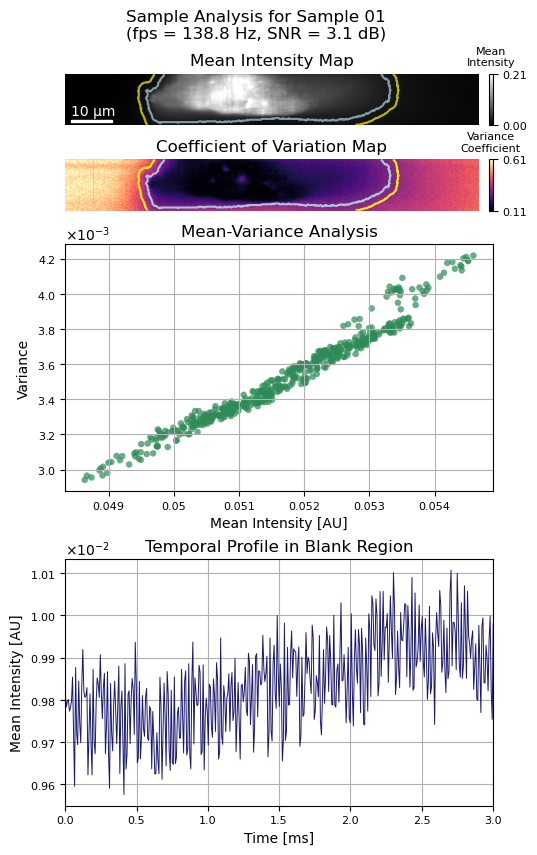

Analyzing Sample 28
Mean intensity: 0.0144
Standard deviation of intensity: 0.013
Intensity Range: 0-0.224
Background temporal noise (standard deviation): 0.00454


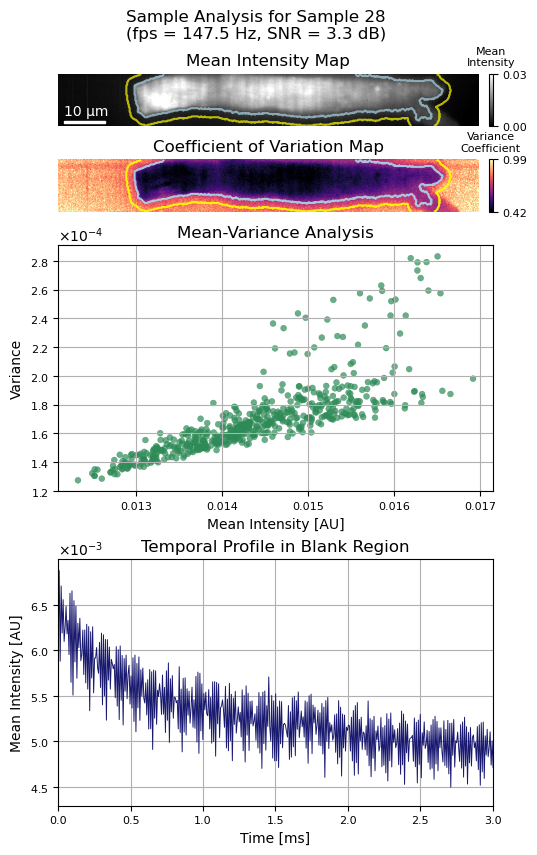

Analyzing Sample 36
Mean intensity: 0.019
Standard deviation of intensity: 0.0214
Intensity Range: 0.000125-0.164
Background temporal noise (standard deviation): 0.00236


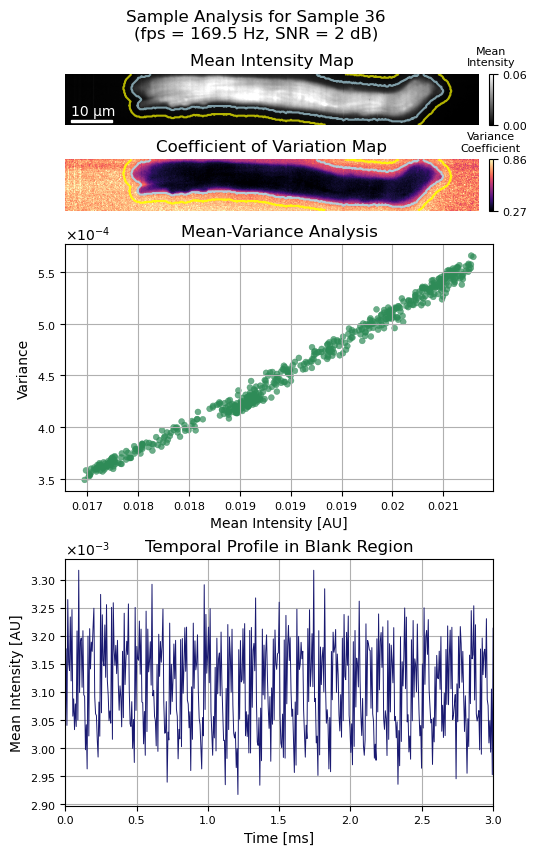

Analyzing Sample 38
Mean intensity: 0.0102
Standard deviation of intensity: 0.00831
Intensity Range: 0-0.099
Background temporal noise (standard deviation): 0.00229


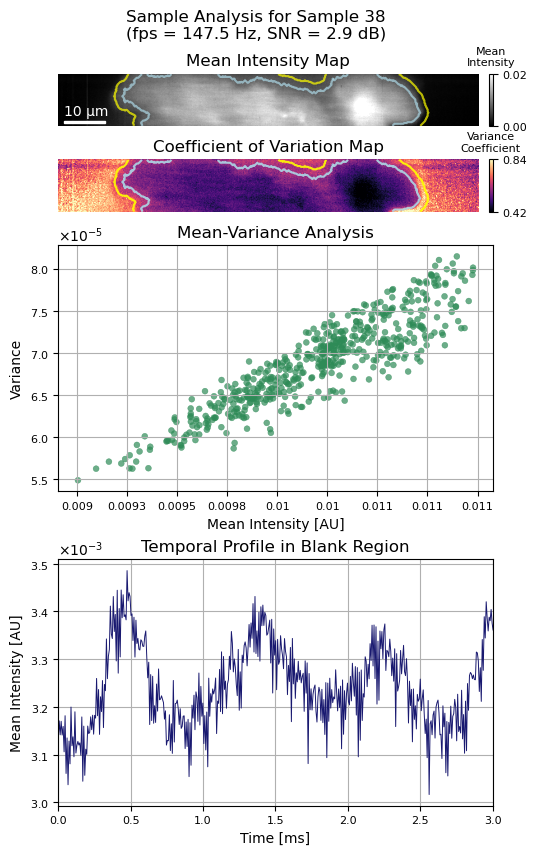

In [41]:
if __name__ == "__main__":
    # extended_analysis(sample_ids, dataset, fps_dict, snr_dict)
    ids = ["01", "28", "36", "38"]
    simple_analysis(ids, dataset, fps_dict, snr_dict)

### Plot Sample Event Instances

In [332]:
from utils.visualization_tools import get_spark_signal, get_spark_2d_signal
from data.data_processing_tools import detect_spark_peaks, detect_puff_centers
from matplotlib import cm
from scipy.ndimage import gaussian_filter, find_objects

In [344]:
sample_id = "34"

print(f"Analyzing Sample {sample_id}")
idx = dataset.sample_ids.index(sample_id)
original_movie = dataset.get_movies()[idx]
labels_mask = dataset.get_labels()[idx]
events_mask = dataset.get_instances()[idx]
movie_fps = fps_dict[sample_id]


# define smooth input movie used for plotting
smooth_movie = gaussian_filter(original_movie, sigma=1)

Analyzing Sample 34


#### Spark

In [330]:
sparks_mask = np.where(labels_mask == 1, events_mask, 0)

# get all spark peaks
spark_coords = detect_spark_peaks(
    movie=original_movie,
    instances_mask=sparks_mask,
    sigma=2,
    max_filter_size=10,
    return_mask=False,
)

# assign a slice to each peak
spark_slices = []
for t, y, x in spark_coords:
    event_nb = sparks_mask[t, y, x]
    event_roi = sparks_mask == event_nb
    event_obj = find_objects(event_roi)[0]
    spark_slices.append(event_obj)


print(f"Number of detected spark peaks: {len(spark_coords)}")

Number of detected spark peaks: 23


In [329]:
# event coordinates
event_id = 20
t, y, x = spark_coords[event_id]
event_slice = spark_slices[event_id]
print(f"Plotting Ca2+ Spark at t={t}, y={y}, x={x}")
# signal parameters
radius = 4
t_context_duration = 30

spatial_context = 5  # consider extended ROI

Plotting Ca2+ Spark at t=240, y=23, x=197


In [272]:
# # Code to select a specific spark to analyze
# for t,y,x in spark_coords:
#     print(f"Analyzing Spark at t={t}, y={y}, x={x}")
#     frames, signal, (y, x), start, stop = get_spark_signal(
#         video=original_movie,
#         sparks_labelled=np.where(labels_mask==1, events_mask, 0),
#         center=(t, y, x),
#         radius=radius,
#         context_duration=context_duration,
#         return_info=True,
#     )

#     # Plot the signal
#     plt.figure(figsize=(6, 3))
#     plt.suptitle("Temporal Profile of Mean Intensity around a Sample Ca$^{2+}$ Spark", y=.9)

#     # Use ms in x axis instead of frames
#     t_axis = np.linspace(
#         0, len(frames) / movie_fps, num=len(frames)
#     )
#     start_ms = (start-frames[0]) / movie_fps
#     stop_ms = (stop-frames[0]) / movie_fps
#     plt.axvspan(start_ms, stop_ms, facecolor="green", alpha=0.25)
#     sns.lineplot(
#         ax=plt.gca(),
#         x=t_axis,
#         y=signal,
#         color="darkgreen",
#         linewidth=0.7,
#     )

#     plt.xlabel("Time [ms]")
#     plt.ylabel("Mean Intensity [AU]")

#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

In [173]:
# for (t, y, x), spark_slice in zip(spark_coords, spark_slices):
#     print(f"Analyzing Spark at t={t}, y={y}, x={x}")

#     # Plot 2D signal
#     # plt.figure(figsize=(10,6))
#     plt.figure(figsize=(6, 3))
#     plt.suptitle("2D Surface Plot of a Sample Ca$^{2+}$ Spark", y=0.8)

#     _, _, _, y_axis, x_axis, signal_2d = get_spark_2d_signal(
#         video=original_movie,
#         slices=spark_slices[event_id],
#         coords=(t, y, x),
#         spatial_context=spatial_context,
#         sigma=2,
#         return_info=True,
#     )

#     # Convert the x and y axis μm (1 pixel = 0.267 μm)
#     x_axis_um = (x_axis - x_axis[0]) * 0.267
#     y_axis_um = (y_axis - y_axis[0]) * 0.267

#     X, Y = np.meshgrid(x_axis_um, y_axis_um)

#     # Set up a 3D plot
#     ax = plt.subplot(1, 1, 1, projection="3d")

#     # Plot the surface
#     # surf = ax.plot_surface(Y, X, signal_2d, cmap=cm.coolwarm, linewidth=0, edgecolor='k', antialiased=True)
#     surf = ax.plot_surface(
#         Y,
#         X,
#         signal_2d,
#         cmap=cm.coolwarm,
#         rstride=1,
#         cstride=1,
#         linewidth=0,
#         edgecolor="k",
#         antialiased=False,
#     )

#     # Customize the z axis
#     ax.set_zlim(signal_2d.min(), signal_2d.max())

#     # Add color bar which maps values to colors
#     cbar = plt.colorbar(surf, shrink=0.5, aspect=10)
#     cbar.set_label("Mean Intensity [AU]")

#     # Labels
#     ax.set_xlabel("X [μm]", fontsize=10, labelpad=10)
#     ax.set_ylabel("Y [μm]", fontsize=10, labelpad=10)
#     ax.set_zlabel("Mean Intensity [AU]", fontsize=10, labelpad=10)

#     # Format the tick labels on the x and y axes to display one decimal digit
#     ax.xaxis.set_major_formatter(
#         ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x))
#     )
#     ax.yaxis.set_major_formatter(
#         ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x))
#     )

#     # Rotate x-, y-, and z-axis labels
#     ax.xaxis.set_rotate_label(False)
#     ax.yaxis.set_rotate_label(False)
#     ax.zaxis.set_rotate_label(False)  # Prevent automatic rotation

#     # Manually rotate z-axis label
#     ax.zaxis.label.set_rotation(90)

#     # Set view angle
#     ax.view_init(elev=25, azim=45)

#     # Improve layout
#     plt.tight_layout(pad=2)

#     # Show plot
#     plt.show()

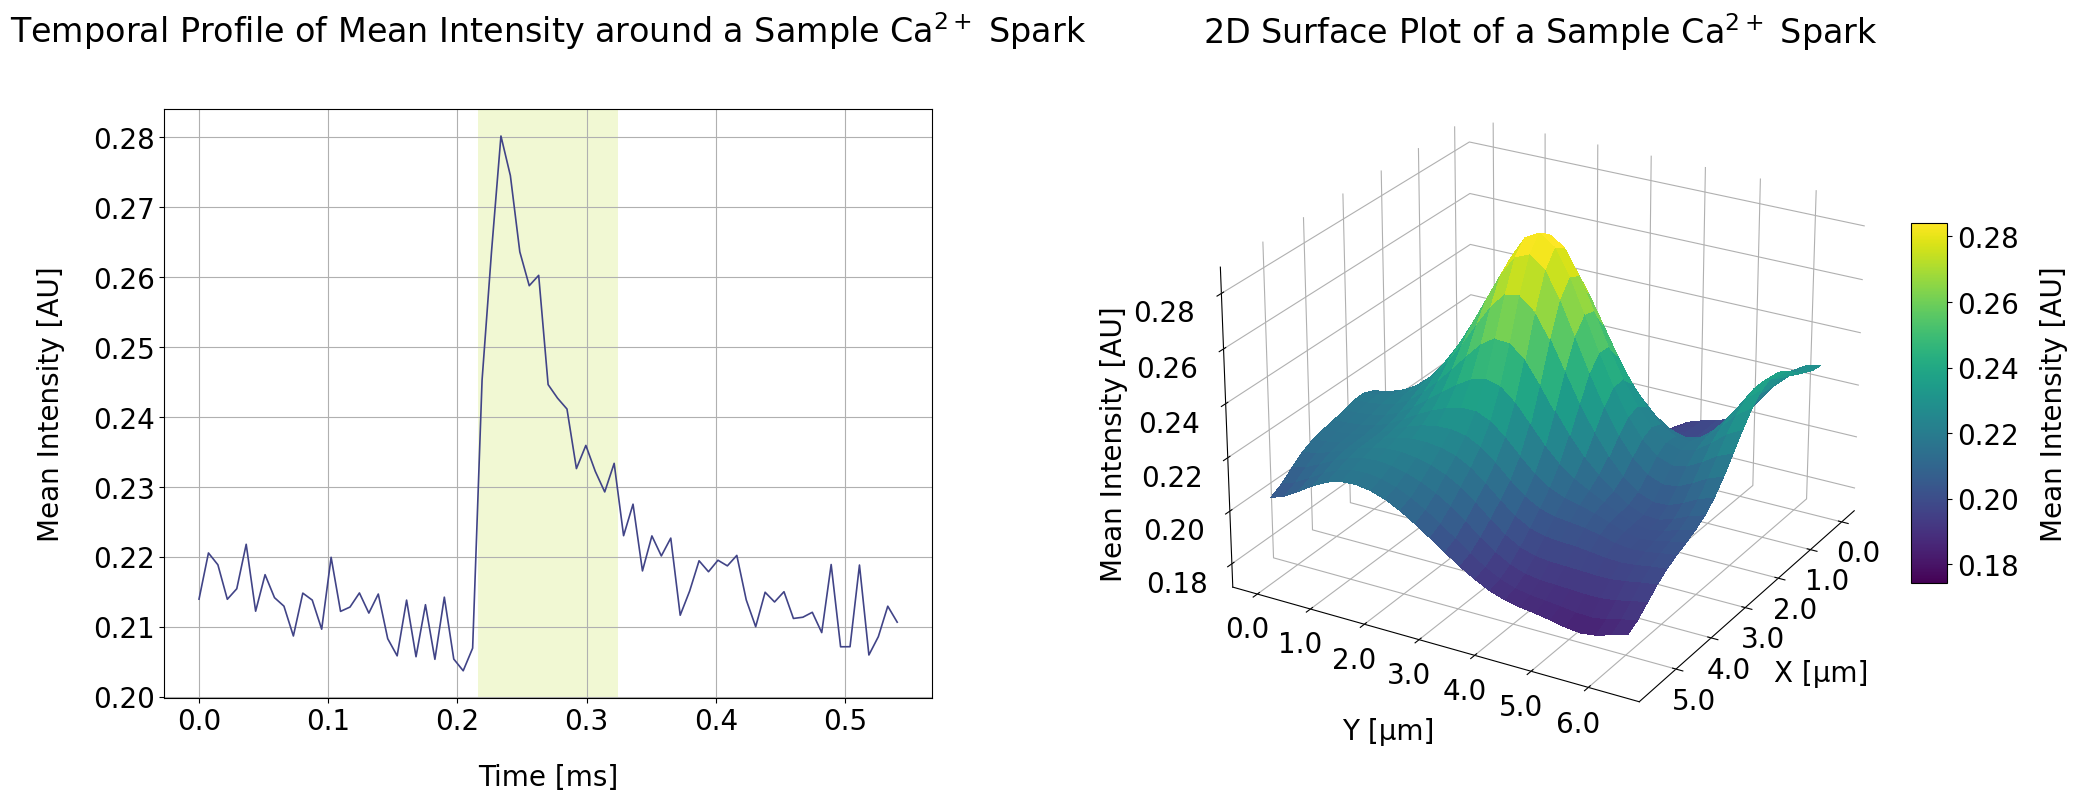

In [326]:
# Set a common font size for all plot elements
plt.rcParams.update({"font.size": 20})

# Create a new figure with two subplots, one for each of the plots
fig = plt.figure(figsize=(24, 12))

# GridSpec lets you specify custom heights and widths
gs = fig.add_gridspec(3, 2, width_ratios=[4, 6], height_ratios=[1, 25, 1])

# First subplot for the temporal profile
ax1 = fig.add_subplot(gs[1, 0])
ax1.set_title(
    "Temporal Profile of Mean Intensity around a Sample Ca$^{2+}$ Spark", y=1.1
)

# Extract the region and calculate the mean intensity over time
frames, signal, (y, x), start, stop = get_spark_signal(
    video=original_movie,
    sparks_labelled=sparks_mask,
    center=(t, y, x),
    radius=radius,
    context_duration=t_context_duration,
    return_info=True,
)

# Use ms in x axis instead of frames
t_axis = np.linspace(0, len(frames) / movie_fps, num=len(frames))
start_ms = (start - frames[0]) / movie_fps
stop_ms = (stop - frames[0]) / movie_fps
ax1.axvspan(start_ms, stop_ms, facecolor=cm.viridis(0.9), alpha=0.2)

sns.lineplot(
    ax=ax1,
    x=t_axis,
    y=signal,
    color=cm.viridis(0.2),
    linewidth=1.2,
)

ax1.set_xlabel("Time [ms]", labelpad=20)
ax1.set_ylabel("Mean Intensity [AU]", labelpad=20)
ax1.grid(True)

# Second subplot for the 2D surface plot
ax2 = fig.add_subplot(gs[:, 1], projection="3d")
ax2.set_title("2D Surface Plot of a Sample Ca$^{2+}$ Spark", y=1.075)

ax2.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

_, _, _, y_axis, x_axis, signal_2d = get_spark_2d_signal(
    video=original_movie,
    slices=event_slice,
    coords=(t, y, x),
    spatial_context=spatial_context,
    sigma=2,
    return_info=True,
)

# Convert the x and y axis μm (1 pixel = 0.267 μm)
x_axis_um = (x_axis - x_axis[0]) * 0.267
y_axis_um = (y_axis - y_axis[0]) * 0.267

X, Y = np.meshgrid(x_axis_um, y_axis_um)

# Plot the surface
surf = ax2.plot_surface(
    Y,
    X,
    signal_2d,
    cmap="viridis",
    rstride=1,
    cstride=1,
    linewidth=0,
    edgecolor="k",
    antialiased=False,
)

# Move z-axis ticks further away from the axis (increase the pad value)
for tick in ax2.zaxis.get_major_ticks():
    tick.set_pad(15)

# Customize the z axis
ax2.set_zlim(signal_2d.min(), signal_2d.max())

# Add color bar which maps values to colors
cbar = plt.colorbar(surf, shrink=0.5, aspect=10, ax=ax2, pad=0.01)
cbar.set_label("Mean Intensity [AU]", labelpad=15)

# Labels
ax2.set_xlabel("X [μm]", labelpad=25)
ax2.set_ylabel("Y [μm]", labelpad=25)
ax2.set_zlabel("Mean Intensity [AU]", labelpad=25)

# Don't rotate x-, y-, and z-axis label by 90 degrees
ax2.xaxis.set_rotate_label(False)
ax2.yaxis.set_rotate_label(False)
ax2.zaxis.set_rotate_label(False)

# Rotate z-axis label by 90 degrees
ax2.zaxis.label.set_rotation(90)  # Rotate manually

# Format the tick labels on the x and y axes to display one decimal digit
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: "{:.1f}".format(x)))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: "{:.1f}".format(x)))


# Set view angle
ax2.view_init(elev=25, azim=30)

# Adjust subplots to minimize the whitespace
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.0)

fig.savefig(
    f"movie_{sample_id}_spark_t={t}_y={y}_x={x}.png",
    dpi=300,
    bbox_inches="tight",
    # pad_inches=0.1
)

# Show the combined plot
plt.show()

#### Puff

In [345]:
puffs_mask = np.where(labels_mask == 3, events_mask, 0)

# get all puff centers
puffs_coords = detect_puff_centers(
    movie=original_movie,
    instances_mask=puffs_mask,
    sigma=2,
    max_filter_size=10,
    return_mask=False,
)


# assign a slice to each center
puff_slices = []
for t, y, x in puffs_coords:
    event_nb = puffs_mask[t, y, x]
    event_roi = puffs_mask == event_nb
    event_obj = find_objects(event_roi)[0]
    puff_slices.append(event_obj)

print(f"Number of detected puff centers: {len(puffs_coords)}")

Number of detected puff centers: 3


In [346]:
# event coordinates
event_id = 0
t, y, x = puffs_coords[event_id]
event_slice = puff_slices[event_id]
print(f"Plotting Ca2+ Puff at t={t}, y={y}, x={x}")
# signal parameters
radius = 4
t_context_duration = 30

spatial_context = 8  # consider extended ROI

Plotting Ca2+ Puff at t=198, y=58, x=161


Analyzing Puff at t=198, y=58, x=161


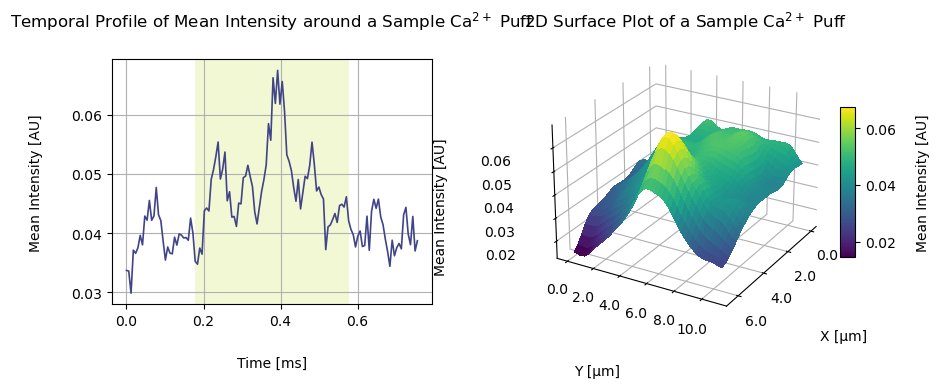

Analyzing Puff at t=13, y=53, x=367


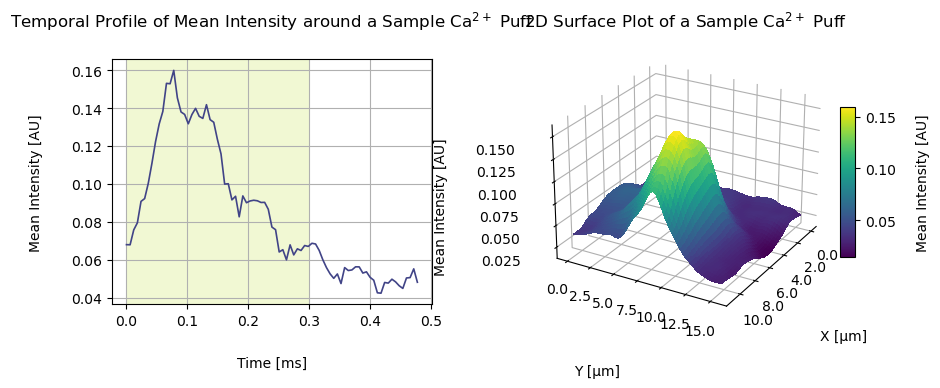

Analyzing Puff at t=667, y=58, x=374


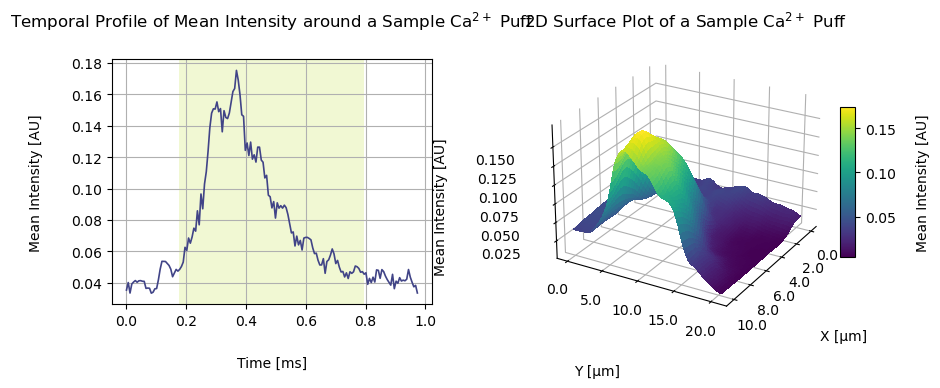

In [347]:
# Set a common font size for all plot elements
plt.rcParams.update({"font.size": 10})


for (t, y, x), puff_slice in zip(puffs_coords, puff_slices):
    print(f"Analyzing Puff at t={t}, y={y}, x={x}")
    # Create a new figure with two subplots, one for each of the plots
    # fig = plt.figure(figsize=(24, 12))
    fig = plt.figure(figsize=(10, 5))

    # GridSpec lets you specify custom heights and widths
    gs = fig.add_gridspec(3, 2, width_ratios=[4, 6], height_ratios=[1, 25, 1])

    # First subplot for the temporal profile
    ax1 = fig.add_subplot(gs[1, 0])
    ax1.set_title(
        "Temporal Profile of Mean Intensity around a Sample Ca$^{2+}$ Puff", y=1.1
    )

    # Extract the region and calculate the mean intensity over time
    frames, signal, (y, x), start, stop = get_spark_signal(
        video=original_movie,
        sparks_labelled=puffs_mask,
        center=(t, y, x),
        radius=radius,
        context_duration=t_context_duration,
        return_info=True,
    )

    # Use ms in x axis instead of frames
    t_axis = np.linspace(0, len(frames) / movie_fps, num=len(frames))
    start_ms = (start - frames[0]) / movie_fps
    stop_ms = (stop - frames[0]) / movie_fps
    ax1.axvspan(start_ms, stop_ms, facecolor=cm.viridis(0.9), alpha=0.2)

    sns.lineplot(
        ax=ax1,
        x=t_axis,
        y=signal,
        color=cm.viridis(0.2),
        linewidth=1.2,
    )

    ax1.set_xlabel("Time [ms]", labelpad=20)
    ax1.set_ylabel("Mean Intensity [AU]", labelpad=20)
    ax1.grid(True)

    # Second subplot for the 2D surface plot
    ax2 = fig.add_subplot(gs[:, 1], projection="3d")
    ax2.set_title("2D Surface Plot of a Sample Ca$^{2+}$ Puff", y=1.075)

    ax2.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax2.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax2.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    _, _, _, y_axis, x_axis, signal_2d = get_spark_2d_signal(
        video=original_movie,
        slices=puff_slice,
        coords=(t, y, x),
        spatial_context=spatial_context,
        sigma=2,
        return_info=True,
    )

    # Convert the x and y axis μm (1 pixel = 0.267 μm)
    x_axis_um = (x_axis - x_axis[0]) * 0.267
    y_axis_um = (y_axis - y_axis[0]) * 0.267

    X, Y = np.meshgrid(x_axis_um, y_axis_um)

    # Plot the surface
    surf = ax2.plot_surface(
        Y,
        X,
        signal_2d,
        cmap="viridis",
        rstride=1,
        cstride=1,
        linewidth=0,
        edgecolor="k",
        antialiased=False,
    )

    # Move z-axis ticks further away from the axis (increase the pad value)
    for tick in ax2.zaxis.get_major_ticks():
        tick.set_pad(15)

    # Customize the z axis
    ax2.set_zlim(signal_2d.min(), signal_2d.max())

    # Add color bar which maps values to colors
    cbar = plt.colorbar(surf, shrink=0.5, aspect=10, ax=ax2, pad=0.01)
    cbar.set_label("Mean Intensity [AU]", labelpad=15)

    # Labels
    ax2.set_xlabel("X [μm]", labelpad=25)
    ax2.set_ylabel("Y [μm]", labelpad=25)
    ax2.set_zlabel("Mean Intensity [AU]", labelpad=25)

    # Don't rotate x-, y-, and z-axis label by 90 degrees
    ax2.xaxis.set_rotate_label(False)
    ax2.yaxis.set_rotate_label(False)
    ax2.zaxis.set_rotate_label(False)

    # Rotate z-axis label by 90 degrees
    ax2.zaxis.label.set_rotation(90)  # Rotate manually

    # Format the tick labels on the x and y axes to display one decimal digit
    ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: "{:.1f}".format(x)))
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: "{:.1f}".format(x)))

    # Set view angle
    ax2.view_init(elev=25, azim=30)

    # Adjust subplots to minimize the whitespace
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.0)

    # fig.savefig(
    #         f"movie_{sample_id}_spark_t={t}_y={y}_x={x}.png",
    #         dpi=300,
    #         bbox_inches="tight",
    #         # pad_inches=0.1
    #     )

    # Show the combined plot
    plt.show()